<a href="https://colab.research.google.com/github/NeevSabhani/Data-Science/blob/main/Unit4/NeevSabhani_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)

diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [4]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [5]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ', mu=0, sigma=10,
                  dims="aa")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="aa")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh = pm.sample()

Output()

Output()

Output()

Output()

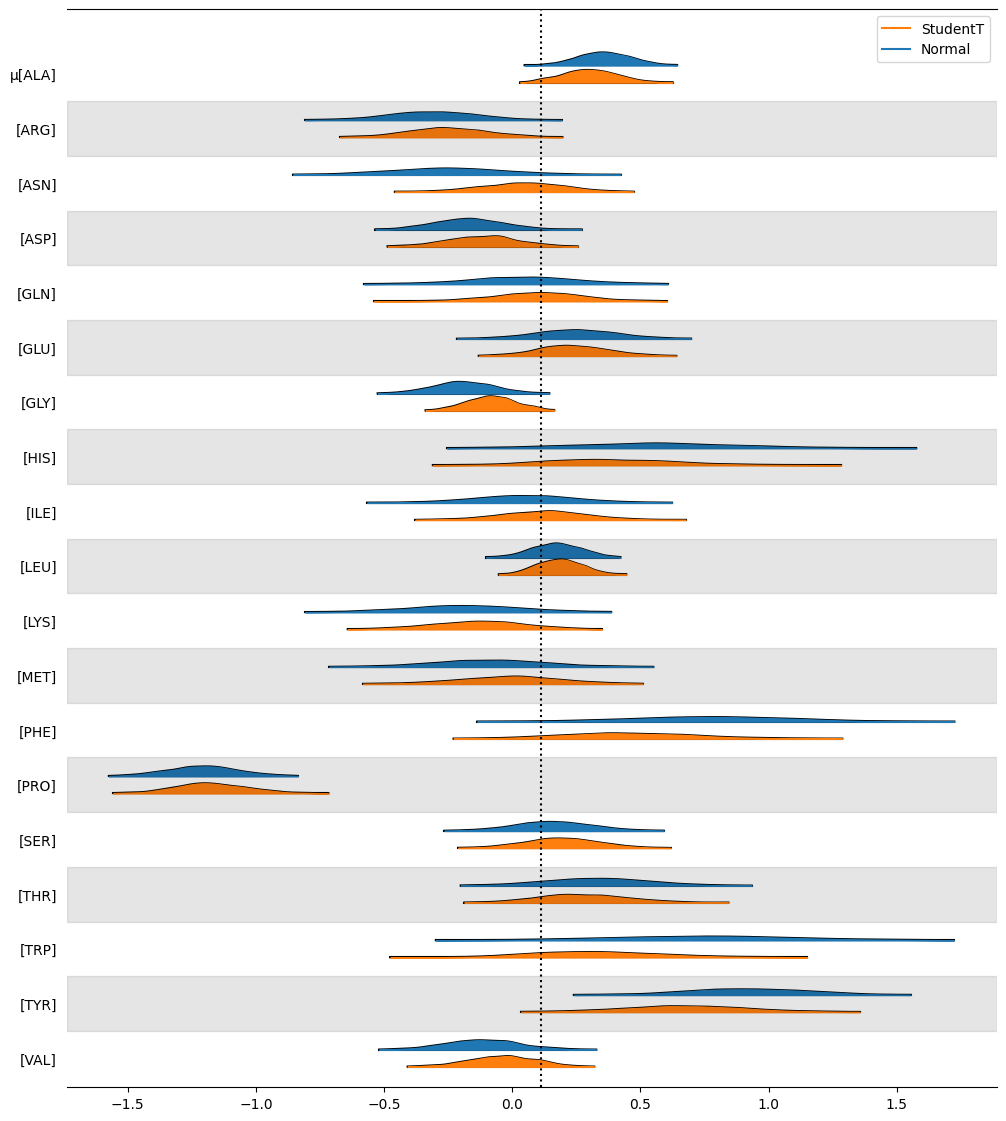

In [6]:
with pm.Model(coords=aa_coords) as cs_studentT_h_model:
    # Hyperpriors: shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu=0, sigma=10, nu=5)
    μ_sd = pm.HalfStudentT('μ_sd', nu=30, sigma=10)  # Change to HalfStudentT with nu parameter
    μ_nu = pm.HalfStudentT('μ_nu', nu=30, sigma=10)

    # Priors for each amino acid: use StudentT instead of Normal
    μ = pm.StudentT('μ', nu=μ_nu, mu=μ_mu, sigma=μ_sd, dims="aa")  # StudentT with nu for group means

    # Priors for standard deviation: HalfStudentT instead of HalfNormal
    σ = pm.HalfStudentT('σ', nu=30, sigma=10, dims="aa")  # HalfStudentT with nu for standard deviation

    v = pm.HalfStudentT('v', nu=30, sigma=10, dims = "aa")

    # Likelihood: use StudentT instead of Normal
    y = pm.StudentT('y', nu=v[aa_idx], mu=μ[aa_idx], sigma=σ[aa_idx], observed=cs_data['diff_TminusE'])

    # Sampling from the posterior
    idata_cs_studentT_h = pm.sample()

# Visualization of posteriors with a ridge plot
axes = az.plot_forest([idata_cs_nh, idata_cs_studentT_h], kind="ridgeplot",
                      model_names=['Normal', 'StudentT'],
                      var_names='μ', combined=True, figsize=(12, 14), hdi_prob=0.997)

# Add mean line for the hierarchical StudentT model
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_studentT_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":")


**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

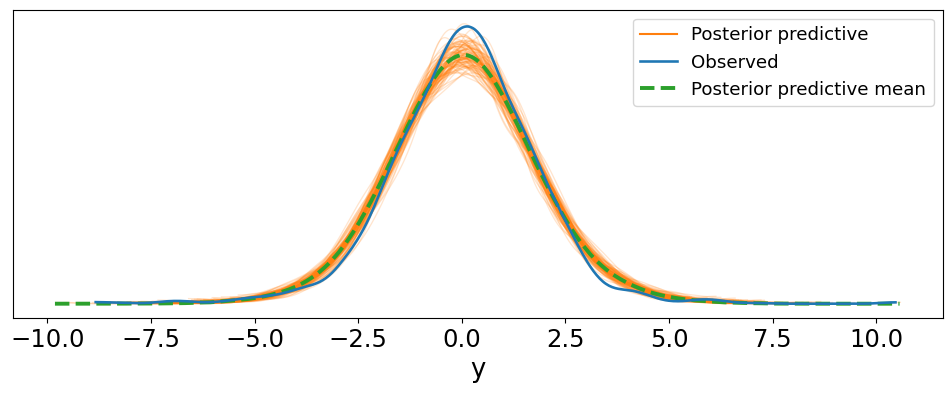

In [7]:
pm.sample_posterior_predictive(idata_cs_nh, model=cs_nh_model, extend_inferencedata=True)

az.plot_ppc(idata_cs_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])


Output()

(-15.0, 15.0)

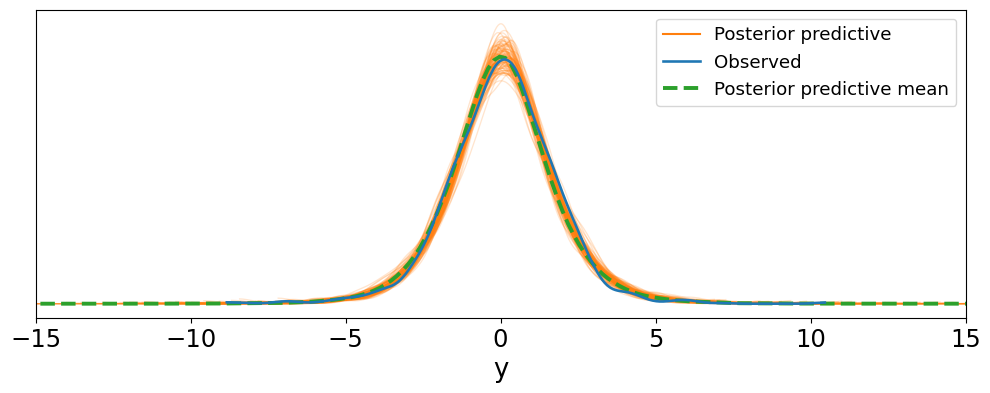

In [10]:
pm.sample_posterior_predictive(idata_cs_studentT_h, model=cs_studentT_h_model, extend_inferencedata=True)

az.plot_ppc(idata_cs_studentT_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"]).set_xlim(-15,15)




The model that we used StudentT to run looks better. The mean of the StudentT model matches up with the obsereved data better than the model ran using Normal and Half-normal (the mean of the Normal model is lower than the obsereved).


**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [16]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [12]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [13]:

with pm.Model(coords=sccr_coords) as sccr_model:
    # Parameters for positions (independent)
    μ_p = pm.Beta('μ_p', mu=1/11, nu = 55, dims="pos")  # independent parameters
    ν_p = pm.Gamma('ν_p', mu=55, sigma=45, dims="pos")  # independent parameters

    # Parameter for players (independent for each player)
    θ = pm.Beta('θ', mu=μ_p[pos_idx], nu=ν_p[pos_idx])  # independent parameters for players

    # This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n=sccr_data.shots.values,  # shots for each player
                    p=θ,  # guess of goals per shot
                    observed=sccr_data.goals.values)  # goals per player

    # Sampling
    idata_sccr = pm.sample(target_accept=0.95)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

In [14]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 0.9998 1.004 1.006 ... 1.001 0.9997 1.002
    μ_p      (pos) float64 32B 1.001 1.0 1.045 1.001
    ν_p      (pos) float64 32B 1.03 1.003 1.211 1.005

###**How do the R hat values compare to the hierarchical model?**

*   **θ**: The θ values of the **non-hierarchical model** are very **similar** to the **hierarchical model** θ values. In the hierarchical model, the θ values 0.9994 - 1.001 which is very similar to the non-hierarchical which had values .9998 - 1.006.
*   **μ_p**: The μ_p values of the **non-hierarchical model** are **better** than the μ_p values of the **hierarchical model**. In the hierarchical model, there is a value over 1.1 while in the non-hierarchical model there is no such value.
*   **v_p**: The v_p values of the **non-hierarchical model** are **worse** than those of the of **hierarchical model**. In the non-hierarchical model, there is a value over 1.1 while there is no such value in the hierarchical model.






array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

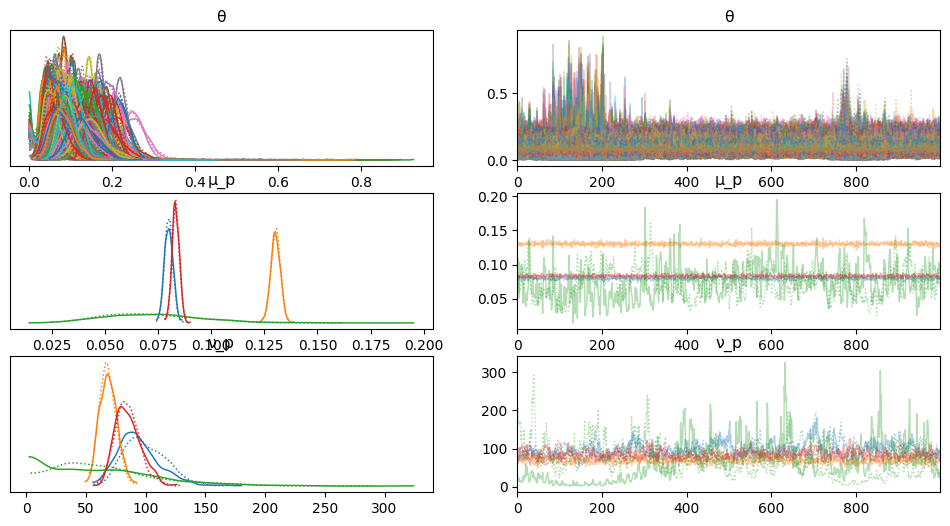

In [15]:
az.plot_trace(idata_sccr)

###**How does this compare to the hierarchical model?**

**Parameter Distributions**:
  * The distributions for the player-level parameters (μ, v) in the hierarchical model appear more dispersed and less compressed compared to the new model.
  * The individual player performance parameter (θ) has a wider spread in the new model, indicating greater variability in player abilities.

**Relationship between Parameters**:
  * The player-level parameters (μ, v) are more tightly coupled in the new model, as evidenced by their closer proximity in the distributions.
  * The hierarchical model seems to have a stronger separation between the μ and v distributions, suggesting a more distinct relationship between these parameters.

**Hierarchical Structure**:
  * The increased spread in the θ distribution for the new model indicates a shift away from a strong hierarchical pooling of information, as seen in the previous hierarchical approach.
  * The new model appears to place more emphasis on capturing individual player variability rather than relying on a tighter hierarchical structure.




**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

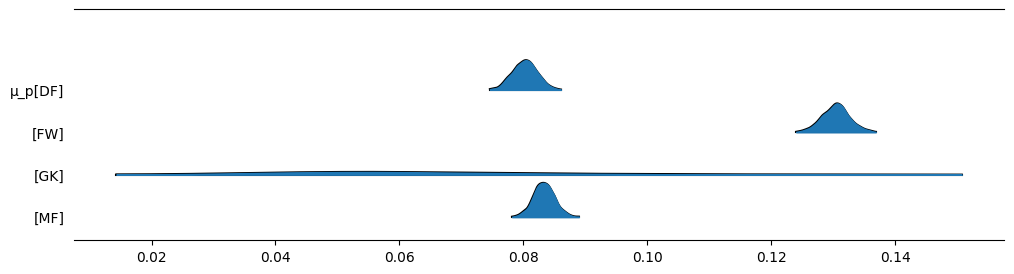

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

  ### **How do these posteriors compare to the hierarchical model we did in class?**
  
  * **Overall Shape Similarity**: The posterior distributions depicted in the image appear to have a similar shape and structure compared to the hierarchical model discussed in class. They exhibit unimodal, approximately normal-like distributions.

  * **Peak Locations**: The peak locations of the distributions for the different variables ([DF], [FW], [GK], [MF]) seem to align well with the hierarchical model, suggesting the central tendencies are comparable.

  * **Skewness**: As you noted, the distributions in the image appear to have a slightly more negative skew compared to the hierarchical model. This indicates the tails of the distributions extend further towards lower values for these parameters.

  * **Goalkeeper (GK) Range**: The posterior distribution for the goalkeeper (GK) parameter extends beyond the 0.14 range, reaching higher values compared to the hierarchical model. This suggests the goalkeeper parameter in this model has a wider, more dispersed posterior distribution.

  Also the hierarchical model has more shrinkage which causes it be not as wide as the non-hierarchical model.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [21]:
sccr_data_no_gk = pd.read_csv(url_sccr)
sccr_data_no_gk = sccr_data_no_gk.query('position != "GK"')
sccr_data_no_gk['position'] = sccr_data_no_gk['position'].astype('category')

In [23]:
pos_idx2 = sccr_data_no_gk.position.cat.codes.values
pos_codes2 = sccr_data_no_gk.position.cat.categories
sccr_coords2 = {"pos":pos_codes2}

pos_codes2

Index(['DF', 'FW', 'MF'], dtype='object')

In [25]:
with pm.Model(coords=sccr_coords2) as soccer_hierarchical_no_gk:
    μ = pm.Beta('μ', alpha=2, beta=20)
    ν = pm.Gamma('ν', mu=55, sigma=45)

    # Parameters for positions (no GK)
    μ_p = pm.Beta('μ_p', mu=μ, nu=ν, dims="pos")
    ν_p = pm.Gamma('ν_p', mu=55, sigma=45, dims="pos")

    # Parameters for players (without goalkeepers)
    θ = pm.Beta('θ', mu=μ_p[pos_idx2], nu=ν_p[pos_idx2])

    # Likelihood (no GK)
    gs = pm.Binomial('gs', n=sccr_data_no_gk['shots'].values, p=θ, observed=sccr_data_no_gk['goals'].values)

    # Sampling
    idata_sccr_h_no_gk = pm.sample(target_accept=0.95)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

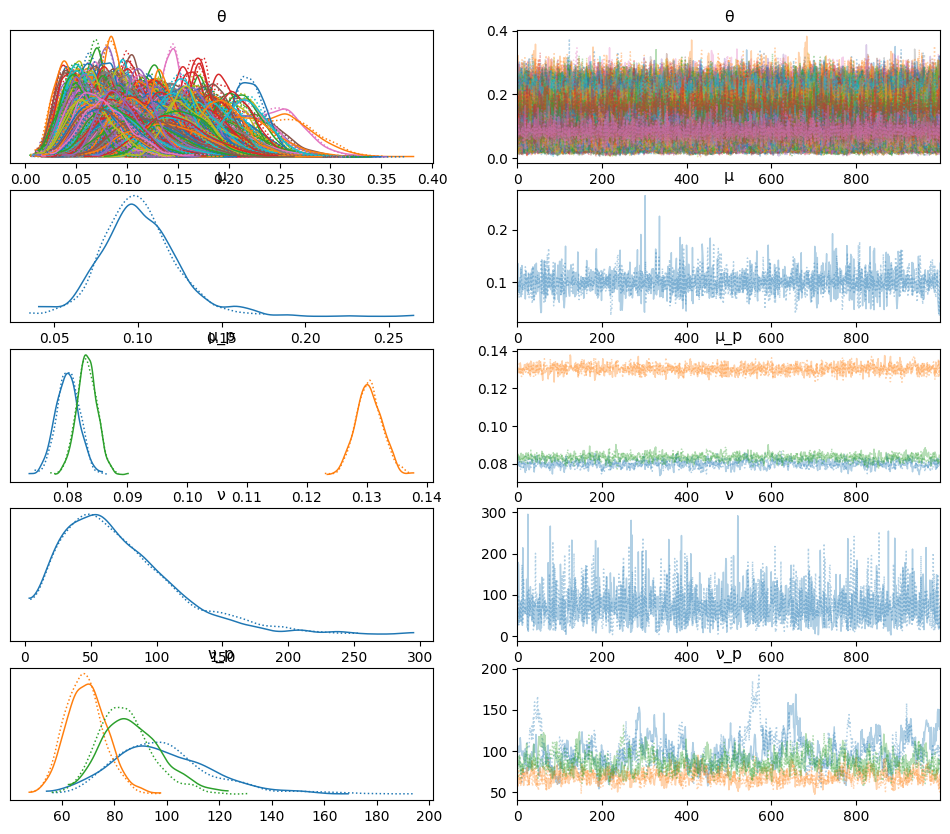

In [26]:
az.plot_trace(idata_sccr_h_no_gk)

###**Which model was easier for pymc to process?**

**The no GK model was easier to run**

  * Because we removed all the GK's, there was overall less data to process so the modeling was faster.
  * Another reason is that since we removed the GK's, the computer doesn't have to process the 0/0 (caused by the fact that they dont score goals, but they also dont shoot shots), which under most circumstances puts more strain on pymc to model. Also, there are instances where goalkeepers do score a lot, so there is lot of very weird variability that occurs which makes it harder for the model to run. Therefore, the removal of GK's makes the model easier to run.


###**What do we lose by dropping Gks from the data set? What do we gain?**

  * We lose some of the variability in the model beacause we miss out on an entire category, which brought some nuance into the model. However, at the expense of the nuanace of the model, we gain some consistency across the model making it easier to read and allowing for more insight in the non goalkeeper positions.